# Convergence Analysis

## Accuracy & convergence

Using some techniques you might have learned in your PDE class, such as separation of variables, you can get a closed expression for the rod problem. It looks like this:

\begin{eqnarray}
T(x,t) = & \nonumber \\
100 - \sum_{n=1}^{\infty} & \frac{400}{(2n-1)\pi}\sin\left(\frac{(2n-1)\pi}{2L}x\right) \exp\left[-\alpha\left(\frac{(2n-1)\pi}{2L}\right)^2t\right]
\end{eqnarray}

Unfortunately, the analytical solution is a bit messy, but at least it gives a good approximation if we evaluate it for large $n$. Let's define a function that will calculate this for us:

### Import packages

In [63]:
import numpy as np 
from matplotlib import pyplot, figure
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 10
from time import time

# For sparse matrices
from scipy.sparse import dia_matrix
from scipy.sparse.linalg.dsolve import spsolve

from scipy.linalg import solve

import warnings
warnings.filterwarnings("ignore")


## Analytic Solution

In [66]:
from math import pi
def T_analytical(x, t, n_max, alpha, L):
    """Computes the exact solution for 1D diffusion with T=100 at x=0 and dT/dx=0 at x=L
        
    Paramters:
    ---------
    x    : array of float
        Spatial position
    t    : float
        Evaluation time
    n_max: int 
        Number of terms to evaluate expression
    alpha: float
        diffusion coefficient
    L    : float
        Size of rod
        
    Returns:
    -------
    T    : array of float
        Temperature at each location x
    """
    T = 100
    for n in range(1,n_max+1):
        k = (2*n-1)*pi/(2*L)
        
        summation = 400/((2*n-1)*pi) * numpy.sin(k*x) * numpy.exp(-alpha*k*k*t)
        T -= summation

    return T    

### Time convergence

We said this method was second-order accurate in time, remember? That's in theory, but we should test that the numerical solution indeed behaves like the theory says.

Leaving $\Delta x$ constant, we'll run the code for different values of $\Delta t$ and compare the result at the same physical time, say $t=n_t\cdot\Delta t=10$, with the analytical expression above.

The initial condition of the rod problem has a very sharp gradient: it suddendly jumps from $0{\rm C}$ to $100{\rm C}$ at the boundary. To resolve that gradient to the point that it doesn't affect time convergence, we would need a very fine mesh, and computations would be very slow. To avoid this issue, we will start from $t=1$ rather than starting from $t=0$.

First, let's define a function that will compute the $L_2$-norm of the error:

In [68]:
def L2_error(T, T_exact):
    """Computes L2 norm of error
    
    Parameters:
    ----------
    T      : array of float
        array with numerical solution
    T_exact: array of float
        array with exact solution
    Returns:
    -------
    e: L2 norm of error
    """
    
    e = numpy.sqrt(numpy.sum((T-T_exact)**2)/numpy.sum(T_exact)**2)
    
    return e

let's compare the Crank-Nicolson schem with the implicit (a.k.a., backward) Euler scheme

In [69]:
import numpy
from scipy.linalg import solve

def CN_generateMatrix(N, sigma):
    """ Computes the matrix for the diffusion equation with Crank-Nicolson
        Dirichlet condition at i=0, Neumann at i=-1
    
    Parameters:
    ----------
    N: int
        Number of discretization points
    sigma: float 
        alpha*dt/dx^2
    
    Returns:
    -------
    A: 2D numpy array of float
        Matrix for diffusion equation
    """
   
    # Setup the diagonal
    d = 2*numpy.diag(numpy.ones(N-2)*(1+1./sigma))
    
    # Consider Neumann BC
    #d[-1,-1] = 1+2./sigma
    
    # Setup upper diagonal
    ud = numpy.diag(numpy.ones(N-3)*-1, 1)
    
    # Setup lower diagonal
    ld = numpy.diag(numpy.ones(N-3)*-1, -1)
    
    A = d + ud + ld
    
    return A

def CN_generateRHS(T, sigma):
    """ Computes right-hand side of linear system for diffusion equation
        with backward Euler
    
    Parameters:
    ----------
    T: array of float
        Temperature at current time step
    sigma: float
        alpha*dt/dx^2
    
    Returns:
    -------
    b: array of float
        Right-hand side of diffusion equation with backward Euler
    """
    
    b = T[1:-1]*2*(1./sigma-1) + T[:-2] + T[2:]
    # Consider Dirichlet BC
    b[0] += T[0]
    
    return b

def CrankNicolson(T, A, nt, sigma):
    """ Advances diffusion equation in time with Crank-Nicolson
   
    Parameters:
    ----------
    T: array of float
        initial temperature profile
    A: 2D array of float
        Matrix with discretized diffusion equation
    nt: int
        number of time steps
    sigma: float
        alpha*td/dx^2
        
    Returns:
    -------
    T: array of floats
        temperature profile after nt time steps
    """
    
    for t in range(nt):
        Tn = T.copy()
        b = CN_generateRHS(Tn, sigma)
        # Use numpy.linalg.solve
        T_interior = solve(A,b)
        T[1:-1] = T_interior
        # Enforce Neumann BC (Dirichlet is enforced automatically)
        #T[-1] = T[-2]

    return T



In [70]:
from scipy.linalg import solve

def BE_generateMatrix(N, sigma):
    """ Computes the matrix for the diffusion equation with backward Euler
        Dirichlet condition at i=0, Neumann at i=-1
    
    Parameters:
    ----------
    T: array of float
        Temperature at current time step
    sigma: float 
        alpha*dt/dx^2
    
    Returns:
    -------
    A: 2D numpy array of float
        Matrix for diffusion equation
    """
   
    # Setup the diagonal
    d = np.diag(np.ones(N-2)*(2+1./sigma))
    
    # Consider Neumann BC
    #d[-1,-1] = 1+1./sigma
    
    # Setup upper diagonal
    ud = np.diag(np.ones(N-3)*-1, 1)
    
    # Setup lower diagonal
    ld = np.diag(np.ones(N-3)*-1, -1)
    
    A = d + ud + ld
    
    return A

def BE_generateRHS(T, sigma, qdx):
    """ Computes right-hand side of linear system for diffusion equation
        with Forward Euler
    
    Parameters:
    ----------
    T: array of float
        Temperature at current time step
    sigma: float
        alpha*dt/dx^2
    qdx: float
        flux at right boundary * dx
    
    Returns:
    -------
    b: array of float
        Right-hand side of diffusion equation with backward Euler
    """
    
    b = T[1:-1]*1./sigma
    # Consider Dirichlet BC
    b[0] += T[0]
    # Consider Neumann BC
    #b[-1] += qdx
    
    return b

def implicit_btcs(T, A, nt, sigma, qdx):
    """ Advances diffusion equation in time with implicit central scheme
   
    Parameters:
    ----------
    T: array of float
        initial temperature profile
    A: 2D array of float
        Matrix with discretized diffusion equation
    nt: int
        number of time steps
    sigma: float
        alpha*td/dx^2
        
    qdx: float
        flux at right boundary * dx
    Returns:
    -------
    T: array of floats
        temperature profile after nt time steps
    """
    
    for t in range(nt):
        Tn = T.copy()
        b = BE_generateRHS(Tn, sigma, qdx)
        # Use numpy.linalg.solve
        T_interior = solve(A,b)
        T[1:-1] = T_interior 
        # Enforce Neumann BC (Dirichlet is enforced automatically)
        #T[-1] = T[-2] + qdx

    return T



Let's do the runs

In [71]:
nx = 1001
dx = L/(nx-1)

dt_values = numpy.asarray([1.0, 0.5, 0.25, 0.125])
error = numpy.zeros(len(dt_values))
error_btcs = numpy.zeros(len(dt_values))

t_final = 10
t_initial = 1

x = numpy.linspace(0,L,nx)

Ti =  T_analytical(x, t_initial, 100, alpha, L)
T_exact = T_analytical(x, t_final, 100, alpha, L)

for i,dt in enumerate(dt_values):
    sigma = alpha*dt/dx**2

    nt = int((t_final-t_initial)/dt)
    
    A = CN_generateMatrix(nx, sigma)
    
    A_btcs = BE_generateMatrix(nx, sigma)

    T = CrankNicolson(Ti.copy(), A, nt, sigma)
    
    error[i] = L2_error(T,T_exact)
    
    T = implicit_btcs(Ti.copy(), A_btcs, nt, sigma,0)
    
    error_btcs[i] = L2_error(T,T_exact)
    

and Plot

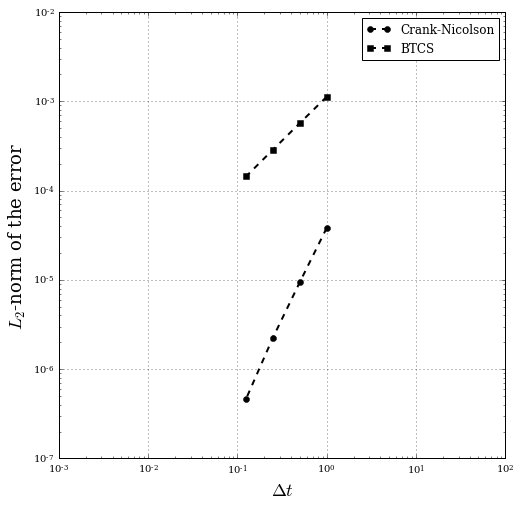

In [72]:
pyplot.figure(figsize=(8,8))
pyplot.grid(True)
pyplot.xlabel(r'$\Delta t$', fontsize=18)
pyplot.ylabel(r'$L_2$-norm of the error', fontsize=18)
pyplot.axis('equal')
pyplot.loglog(dt_values, error, color='k', ls='--', lw=2, marker='o')
pyplot.loglog(dt_values, error_btcs, color='k', ls='--', lw=2, marker='s')
pyplot.legend(['Crank-Nicolson', 'BTCS']);

In [73]:
error

array([  3.81125927e-05,   9.41813943e-06,   2.25089054e-06,
         4.63970974e-07])

See how the error drops four times when the time step is halved? This method is second order in time!

Clearly, Crank-Nicolson (circles) converges faster than backward Euler (squares)! Not only that, but also the error curve is shifted down: Crank-Nicolson is more accurate.

If you look closely, you'll realize that the error in Crank-Nicolson decays about twice as fast than backward Euler: it's a second versus first order method!

### Spatial convergence

To study spatial convergence, we will run the code for meshes with 21, 41, 81 and 161 points, and compare them at the same non-dimensional time, say $t=20$. 

Let's start by defining a function that will do everything for us

In [74]:
nx_values = numpy.asarray([11, 21, 41, 81, 161])

dt = 0.1
error = numpy.zeros(len(nx_values))

t_final = 20

x = numpy.linspace(0,L,nx)

for i,nx in enumerate(nx_values):
    
    dx = L/(nx-1)
    x = numpy.linspace(0,L,nx)
   
    sigma = alpha*dt/dx**2

    nt = int(t_final/dt)
    
    A = CN_generateMatrix(nx, sigma)

    Ti = numpy.zeros(nx)
    Ti[0] = 100
      
    T = CrankNicolson(Ti.copy(), A, nt, sigma)
    
    T_exact = T_analytical(x, t_final, 100, alpha, L)
    
    error[i] = L2_error(T,T_exact)

and PLOT

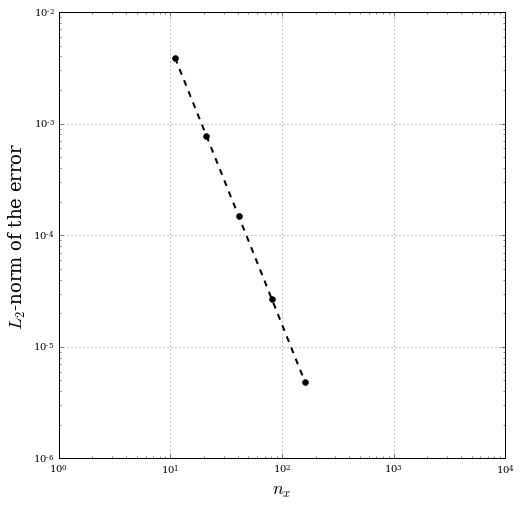

In [75]:
pyplot.figure(figsize=(8,8))
pyplot.grid(True)
pyplot.xlabel(r'$n_x$', fontsize=18)
pyplot.ylabel(r'$L_2$-norm of the error', fontsize=18)
pyplot.axis('equal')
pyplot.loglog(nx_values, error, color='k', ls='--', lw=2, marker='o');

That looks good! See how for each quadrant we go right, the error drops two quadrants going down (and even a bit better!).